In [2]:
# Last mod: FA 2023 Feb 17 - some beautifications

# Testing XGBoost ages for some science cases

First, let's import some libraries:

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter

import astropy.table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, Column, MaskedColumn, join
from astropy.visualization import astropy_mpl_style

from scipy.stats import gaussian_kde
import scipy.ndimage as ndimage
import os.path

from time import time
from sklearn import manifold, datasets

from itertools import product
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15) 

In [4]:
dr17_master = Table.read("/home/friedel/Astro/Spectro/APOGEE/data/DR17/APOGEE_DR17_MASTER_Feb2023.fits")
chem_age = np.isfinite(dr17_master['spec_age_feb2023'])

our_cat  = dr17_master[chem_age]

In [5]:
our_cat.columns

<TableColumns names=('APOGEE_ID','GaiaEDR3_sourceID','TARGET_ID','ASPCAP_ID','TELESCOPE','FIELD','RA','DEC','GLON','GLAT','J','J_ERR','H','H_ERR','K','K_ERR','AK_TARG','AK_TARG_METHOD','AK_WISE','SFD_EBV','TARGFLAGS','SURVEY','PROGRAMNAME','NVISITS','SNREV','STARFLAGS','ANDFLAGS','VHELIO_AVG','VSCATTER','VERR','N_COMPONENTS','ASPCAP_GRID','FPARAM','ASPCAP_CHI2','PARAM','ASPCAPFLAGS','FELEM','FELEM_ERR','X_H','X_H_ERR','X_M','X_M_ERR','ELEM_CHI2','ELEMFRAC','ELEMFLAG','EXTRATARG','X_H_SPEC','X_M_SPEC','TEFF','TEFF_ERR','LOGG','LOGG_ERR','M_H','M_H_ERR','ALPHA_M','ALPHA_M_ERR','VMICRO','VMACRO','VSINI','TEFF_SPEC','LOGG_SPEC','C_FE','C_FE_SPEC','C_FE_ERR','C_FE_FLAG','CI_FE','CI_FE_SPEC','CI_FE_ERR','CI_FE_FLAG','N_FE','N_FE_SPEC','N_FE_ERR','N_FE_FLAG','O_FE','O_FE_SPEC','O_FE_ERR','O_FE_FLAG','NA_FE','NA_FE_SPEC','NA_FE_ERR','NA_FE_FLAG','MG_FE','MG_FE_SPEC','MG_FE_ERR','MG_FE_FLAG','AL_FE','AL_FE_SPEC','AL_FE_ERR','AL_FE_FLAG','SI_FE','SI_FE_SPEC','SI_FE_ERR','SI_FE_FLAG','S_FE','S_FE

## Age vs. location in the Galaxy (RGal vs ZGal, XGal vs YGal)

In [77]:
def create_median_map(Xin, Yin, weights, xy_range, bins=50, 
                      minstars=2, gaussfilter=None):
    # Weighted 2D Histogram
    H,X,Y=np.histogram2d(Xin, Yin, weights=weights, 
                         bins=bins,range=[xy_range[:2], xy_range[2:]])
    XX,YY=np.meshgrid(X,Y)
    X1 = (X[:-1] - X[1:])/2 +X[:-1]
    Y1 = (Y[:-1] - Y[1:])/2 + Y[:-1]
    
    # Unweighted 2D Histogram
    Hc,X1,X2 = np.histogram2d(Xin, Yin, bins=bins, range=[xy_range[:2], xy_range[2:]])
    Hc[Hc<minstars]=1
    Ht = H/Hc
    
    # Gaussian filter
    if gaussfilter is not None:
        H = ndimage.gaussian_filter(Ht,sigma=gaussfilter,order=0)
    else:
        H = Ht
    # Filter out bins with less than minstars
    Hc,X,Y=np.histogram2d(Xin, Yin, bins=bins,range=[xy_range[:2], xy_range[2:]])
    H[Hc<minstars]=np.NaN
    return XX, YY, H

In [78]:
def flare(R, Rd=6, z0=.1, z1=.03):
    # Only flare if R > Rw:
    return np.piecewise(R, [R < Rd, R >= Rd], 
                        [z0, lambda R:z0 + z1 * (R-Rd)**2.]) 


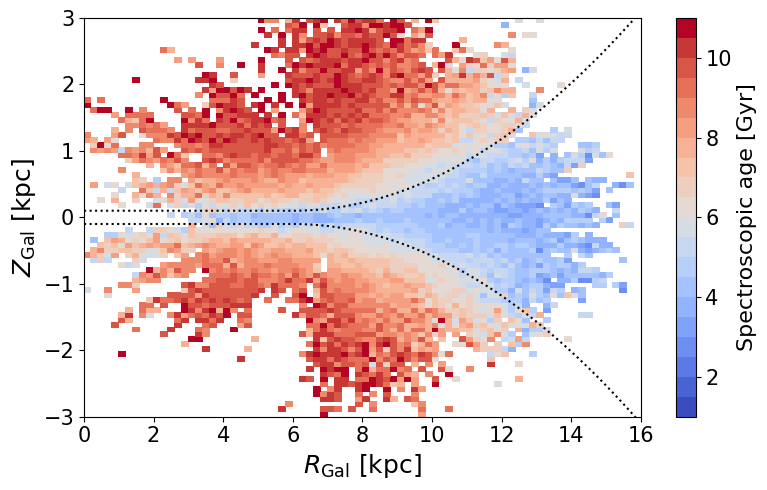

In [79]:
f, (a1) = plt.subplots(1, 1, figsize=(8,5))

rz_range = [0, 16, -3, 3]

XX, YY, H = create_median_map(our_cat["Rg"], our_cat["Zg"],
                              xy_range=rz_range,
                              weights = our_cat['spec_age_feb2023'],
                              bins=80, minstars=3)
cmap = plt.get_cmap('coolwarm', 20)
image = a1.pcolor(XX, YY, H.T, cmap=cmap, vmin=1, vmax=11)
cax = plt.colorbar(image)
cax.set_label(r"Spectroscopic age [Gyr]", fontsize=16)

# Overplot flare? 
xarr = np.linspace(0, 20, 100)
plt.plot(xarr, flare(xarr), c="k", ls="dotted")
plt.plot(xarr, flare(xarr, Rd=6, z0=-.1, z1=-.03), c="k", ls="dotted")

a1.axis(rz_range)
a1.set_xlabel(r"$R_{\rm Gal}$ [kpc]", fontsize=18)
a1.set_ylabel(r"$Z_{\rm Gal}$ [kpc]", fontsize=18)

plt.tight_layout()
plt.savefig("../im/RZ_agecoloured.png")

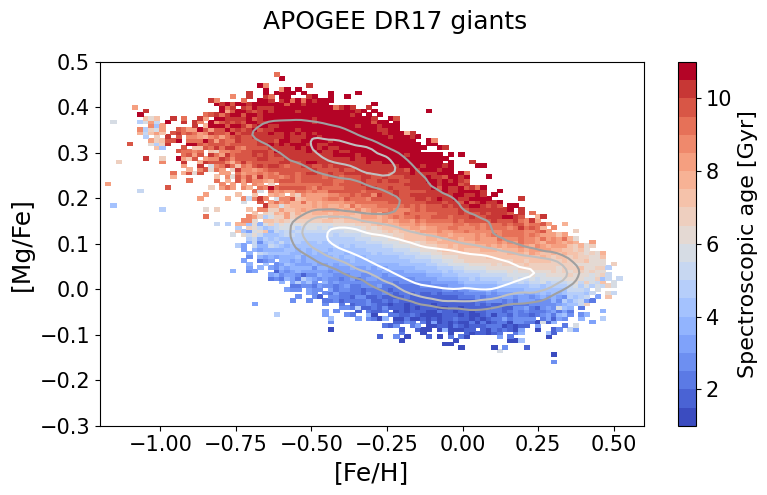

In [9]:
f, (a1) = plt.subplots(1, 1, figsize=(8,5))

mgfe_range = [-1.2, .6, -.3, .5]

XX, YY, H = create_median_map(our_cat["FE_H"], our_cat["MG_FE"],
                              xy_range=mgfe_range,
                              weights = our_cat['spec_age_feb2023'],
                              bins=100)
cmap = plt.get_cmap('coolwarm', 20)
image = a1.pcolor(XX, YY, H.T, cmap=cmap, vmin=1, vmax=11, label="APOGEE DR17 giants")
# Overplot contours
# Unweighted 2D Histogram
Ht,X1,X2 = np.histogram2d(our_cat["FE_H"], our_cat["MG_FE"], 
                          bins=100, range=[mgfe_range[:2], mgfe_range[2:]])
H = ndimage.gaussian_filter(Ht,sigma=(1.0,1.0),order=0)

plt.contour(X1[:-1], X2[:-1], H.T, levels=[40, 80, 160],
            colors=['#A0A0A0', '#C0C0C0', 'white'])

cax = plt.colorbar(image)
cax.set_label(r"Spectroscopic age [Gyr]", fontsize=16)

a1.axis(mgfe_range)
a1.set_xlabel(r"[Fe/H]", fontsize=18)
a1.set_ylabel(r"[Mg/Fe]", fontsize=18)

plt.suptitle("APOGEE DR17 giants", fontsize=18)
plt.tight_layout()
plt.savefig("../im/mgfe_agecoloured.png")

In [10]:
delgadomena = Table.read("../data/DelgadoMena20172019.fits")

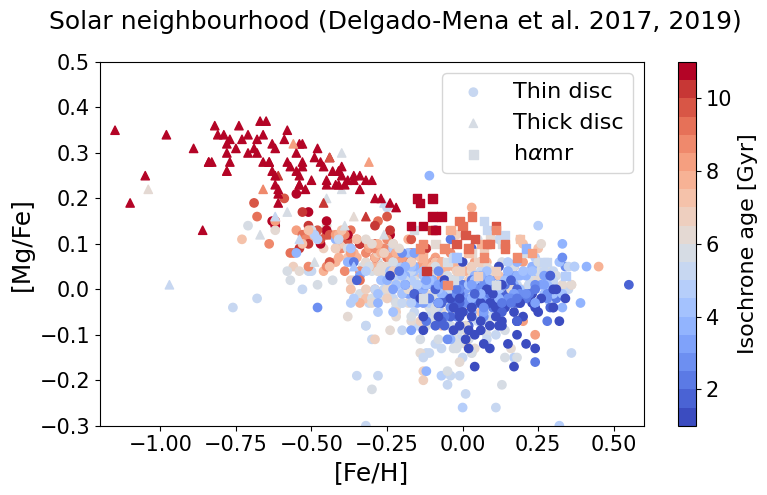

In [11]:
f, (a1) = plt.subplots(1, 1, figsize=(8,5))

mgfe_range = [-1.2, .6, -.3, .5]
cmap = plt.get_cmap('coolwarm', 20)

pops = ["thin", "thick", "high"]
syms = ["o", "^", "s"]
labels = ["Thin disc", "Thick disc", r"h$\alpha$mr"]

for jj in [0,1,2]: 
    sc = plt.scatter(delgadomena["__Fe_H_"][delgadomena["pop"]==pops[jj]], 
                     delgadomena["__MgI_Fe_"][delgadomena["pop"]==pops[jj]], 
                     c=delgadomena["Age"][delgadomena["pop"]==pops[jj]], 
                     cmap=cmap, marker=syms[jj], vmin=1, vmax=11, label=labels[jj])

    plt.legend(loc="upper right", fontsize=16)
cax = plt.colorbar(sc)
cax.set_label(r"Isochrone age [Gyr]", fontsize=16)

a1.axis(mgfe_range)
a1.set_xlabel(r"[Fe/H]", fontsize=18)
a1.set_ylabel(r"[Mg/Fe]", fontsize=18)

plt.suptitle("Solar neighbourhood (Delgado-Mena et al. 2017, 2019)", fontsize=18)
plt.tight_layout()
plt.savefig("../im/mgfe_agecoloured_delgadomena.png")

## Abundance-age relations

In [12]:
kin_age = our_cat['spec_age_feb2023', 'FE_H',
                  'JR_st_m','JPhi_st_m','JZ_st_m'][(our_cat['JR_st_m']>-9.9) & 
                                                   (our_cat['spec_age_feb2023']>0) &
                                                   (our_cat['FE_H']>-9.)]

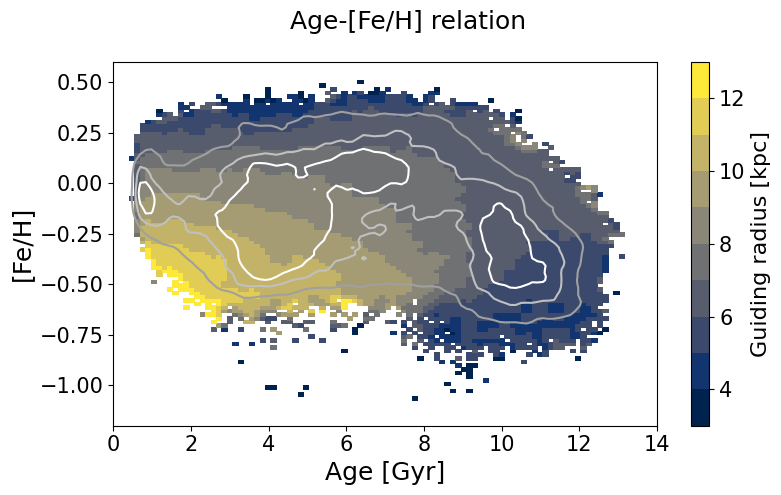

In [91]:
f, (a1) = plt.subplots(1, 1, figsize=(8,5))

agefe_range = [0,14,-1.2, .6]

XX, YY, H = create_median_map(our_cat['spec_age_feb2023'], our_cat["FE_H"],
                              xy_range=agefe_range,
                              weights = our_cat['Rc'],
                              bins=100, minstars=3, gaussfilter=(1,1))
cmap = plt.get_cmap('cividis', 10)
image = a1.pcolor(XX, YY, H.T, cmap=cmap, vmin=3, vmax=13, label="APOGEE DR17 giants")
# Overplot contours
# Unweighted 2D Histogram
Ht,X1,X2 = np.histogram2d(our_cat['spec_age_feb2023'], our_cat["FE_H"], 
                          bins=100, range=[agefe_range[:2], agefe_range[2:]])
H = ndimage.gaussian_filter(Ht,sigma=(1.0,1.0),order=0)

plt.contour(X1[:-1], X2[:-1], H.T, levels=[20, 40, 60],
            colors=['#A0A0A0', '#C0C0C0', 'white'])

cax = plt.colorbar(image)
cax.set_label(r"Guiding radius [kpc]", fontsize=16)

a1.axis(agefe_range)
a1.set_xlabel(r"Age [Gyr]", fontsize=18)
a1.set_ylabel(r"[Fe/H]", fontsize=18)

plt.suptitle("Age-[Fe/H] relation", fontsize=18)
plt.tight_layout()
plt.savefig("../im/agefe_Rcoloured.png")

### Compare to the bimodal age-[Fe/H] relation found by Nissen+2020

In [14]:
nissen = Table.read("../data/Nissen2020.fit")
nissen

HD,Teff,logg-sp,Vturb,__Fe_H_,__alpha_Fe_,Zs,logL,Age,e_Age,Mass,logg-ph,Ys,Simbad,_RA,_DE,__C_Fe_,__O_Fe_,__Na_Fe_,__Mg_Fe_,__Al_Fe_,__Si_Fe_,__Ca_Fe_,__Ti_Fe_,__Cr_Fe_,__Ni_Fe_,__Sr_Fe_,__Y_Fe_
,K,log(cm.s**-2),km / s,log(Sun),log(Sun),,log(Sun),Gyr,Gyr,log(Sun),log(cm.s**-2),,,deg,deg,log(Sun),log(Sun),log(Sun),log(Sun),log(Sun),log(Sun),log(Sun),log(Sun),log(Sun),log(Sun),log(Sun),log(Sun)
int32,int32,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,bytes6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
361,5892,4.524,1.05,-0.13,-0.003,0.0135,-0.021,1.5,0.9,1.01,4.497,0.255,Simbad,2.06817,-14.82449,-0.039,0.01,-0.072,-0.014,-0.042,-0.013,0.027,0.019,0.002,-0.056,0.106,0.079
1461,5760,4.372,1.03,0.19,0.009,0.0275,0.077,5.5,0.5,1.05,4.378,0.257,Simbad,4.67445,-8.053,-0.032,-0.108,0.103,0.007,0.044,0.014,-0.016,0.007,0.005,0.045,-0.052,-0.039
2071,5724,4.486,0.96,-0.087,0.013,0.0152,-0.076,4.1,0.9,0.96,4.481,0.245,Simbad,6.17729,-53.984,-0.02,-0.022,-0.032,0.001,-0.001,0.002,0.024,0.029,0.005,-0.029,0.032,0.039
4915,5662,4.513,0.93,-0.212,0.042,0.0121,-0.154,3.8,1.3,0.92,4.52,0.245,Simbad,12.7952,-5.03928,0.02,0.039,-0.039,0.048,0.02,0.014,0.045,0.064,0.006,-0.037,0.036,0.032
6204,5857,4.517,1.05,0.046,-0.038,0.0188,-0.034,-0.4,1.0,1.05,4.516,0.27,Simbad,15.73925,-9.86124,-0.129,-0.097,-0.107,-0.062,-0.078,-0.044,0.019,-0.009,0.005,-0.064,0.129,0.122
7134,5930,4.322,1.2,-0.335,0.046,0.0093,0.171,8.4,0.5,0.95,4.29,0.208,Simbad,17.88367,-12.84308,0.029,0.094,-0.033,0.037,0.021,0.049,0.047,0.052,-0.018,-0.029,-0.015,-0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204313,5767,4.365,1.05,0.182,0.008,0.027,0.105,6.0,0.5,1.05,4.353,0.253,Simbad,322.05086,-21.72625,0.009,-0.08,0.096,0.01,0.034,0.015,-0.025,-0.001,0.003,0.038,-0.063,-0.058


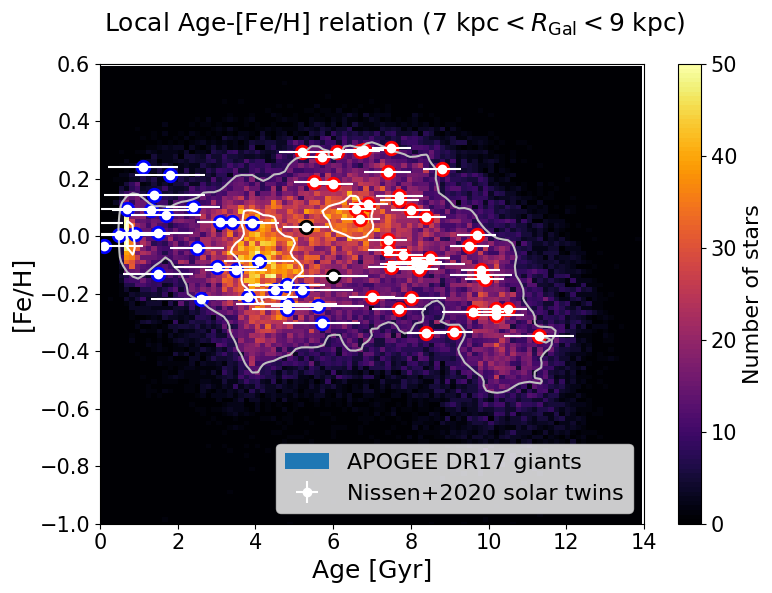

In [15]:
f, (a1) = plt.subplots(1, 1, figsize=(8,6))

agefe_range = [0,14,-1., .6]

sel       = (our_cat['Rg'] > 7) & (our_cat['Rg'] < 9) & (abs(our_cat['Zg']) < 1.)

cmap = plt.get_cmap('inferno', 100)
# Overplot contours
# Unweighted 2D Histogram
Ht,X1,X2 = np.histogram2d(our_cat['spec_age_feb2023'][sel], our_cat["FE_H"][sel], 
                          bins=100, range=[agefe_range[:2], agefe_range[2:]])
image = a1.pcolor(X1[:-1], X2[:-1], Ht.T, cmap=cmap, vmax=50, label=r"APOGEE DR17 giants")


H = ndimage.gaussian_filter(Ht,sigma=(1,1),order=0)

plt.contour(X1[:-1], X2[:-1], H.T, levels=[10, 30],
            colors=['#C0C0C0', 'white'])

plt.errorbar(nissen["Age"], nissen["__Fe_H_"], 
             xerr=nissen["e_Age"], yerr=0.01, fmt = 'o', c="w",
             label="Nissen+2020 solar twins")

cax = plt.colorbar(image)
cax.set_label(r"Number of stars", fontsize=16)

a1.axis(agefe_range)
a1.set_xlabel(r"Age [Gyr]", fontsize=18)
a1.set_ylabel(r"[Fe/H]", fontsize=18)

plt.legend(loc="lower right", fontsize=16)

# Nissen colors:
young = (nissen["__Fe_H_"] < -0.2 * (nissen["Age"]-4.5))
old   = (nissen["__Fe_H_"] > -0.2 * (nissen["Age"]-5.9))

plt.scatter(nissen["Age"][young], nissen["__Fe_H_"][young], 
            edgecolors="b", c="w", linewidths=5)
plt.scatter(nissen["Age"][old], nissen["__Fe_H_"][old], 
            edgecolors="r", c="w", linewidths=5)
plt.scatter(nissen["Age"][~old&~young], nissen["__Fe_H_"][~old&~young], 
            edgecolors="k", c="w", linewidths=5)

plt.suptitle(r"Local Age-[Fe/H] relation (7 kpc$<R_{\rm Gal}<9$ kpc)", fontsize=18)
plt.tight_layout()
plt.savefig("../im/agefe_local.png")

## Age - [Mg/Fe] relation

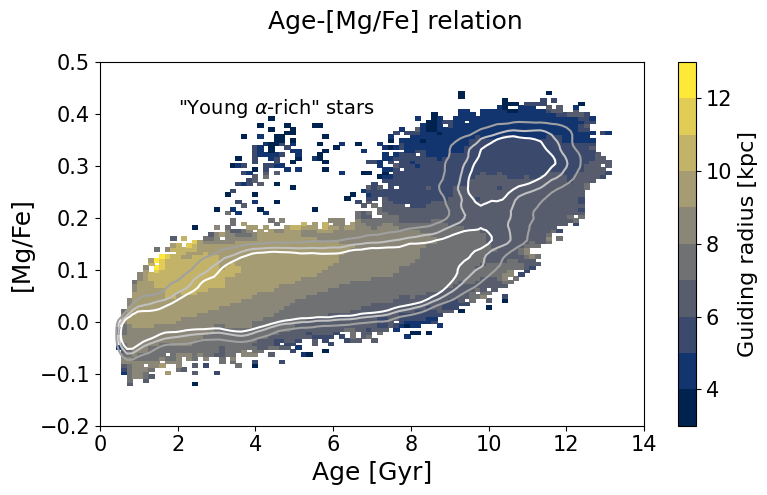

In [104]:
f, (a1) = plt.subplots(1, 1, figsize=(8,5))

agefe_range = [0,14,-.2, .5]

XX, YY, H = create_median_map(our_cat['spec_age_feb2023'], our_cat["MG_FE"],
                              xy_range=agefe_range,
                              weights = our_cat['Rc'],
                              bins=100, minstars=3, gaussfilter=(1,1))
cmap = plt.get_cmap('cividis', 10)
image = a1.pcolor(XX, YY, H.T, cmap=cmap, vmin=3, vmax=13, label="APOGEE DR17 giants")
# Overplot contours
# Unweighted 2D Histogram
Ht,X1,X2 = np.histogram2d(our_cat['spec_age_feb2023'], our_cat["MG_FE"], 
                          bins=100, range=[agefe_range[:2], agefe_range[2:]])
H = ndimage.gaussian_filter(Ht,sigma=(1.0,1.0),order=0)

plt.contour(X1[:-1], X2[:-1], H.T, levels=[20, 40, 60],
            colors=['#A0A0A0', '#C0C0C0', 'white'])

cax = plt.colorbar(image)
cax.set_label(r"Guiding radius [kpc]", fontsize=16)

a1.text(2, .4, r'"Young $\alpha$-rich" stars', fontsize=14)

a1.axis(agefe_range)
a1.set_xlabel(r"Age [Gyr]", fontsize=18)
a1.set_ylabel(r"[Mg/Fe]", fontsize=18)

plt.suptitle("Age-[Mg/Fe] relation", fontsize=18)
plt.tight_layout()
plt.savefig("../im/agemgfe_Rcoloured.png")

## What next?

In [17]:
from scipy.interpolate import make_interp_spline
def running_median(X, Y, nbins=10):
    bins = np.linspace(np.nanquantile(X, 0.005),np.nanquantile(X, 0.995), nbins)
    delta = bins[1]-bins[0]
    idx  = np.digitize(X, bins, right=False)
    med = [np.nanquantile(Y[idx==k], 0.5) for k in range(1, nbins)]
    q16 = [np.nanquantile(Y[idx==k], 0.16) for k in range(1, nbins)]
    q84 = [np.nanquantile(Y[idx==k], 0.84) for k in range(1, nbins)]
    N   = np.array([len(Y[idx==k]) for k in range(1, nbins)])
    return bins[1:] - delta/2, med, q16, q84, N

# Overplot running median
def overplot_trend(X, Y, alpha=0.2, color="k", bins=10, label="", lw=3):
    #lines = mdline(X, Y, bins=bins)
    lines = running_median(X, Y, nbins=bins)
    xnew  = np.linspace(lines[0].min(), lines[0].max(), bins)
    spl   = make_interp_spline(lines[0], lines[1], k=2)
    power_smooth = spl(xnew)
    plt.plot(lines[0], lines[1], ms=50, color=color, lw=lw, label=label)
    plt.fill_between(lines[0], lines[2], lines[3], alpha=alpha, color=color)

In [18]:
our_cat.columns

<TableColumns names=('APOGEE_ID','GaiaEDR3_sourceID','TARGET_ID','ASPCAP_ID','TELESCOPE','FIELD','RA','DEC','GLON','GLAT','J','J_ERR','H','H_ERR','K','K_ERR','AK_TARG','AK_TARG_METHOD','AK_WISE','SFD_EBV','TARGFLAGS','SURVEY','PROGRAMNAME','NVISITS','SNREV','STARFLAGS','ANDFLAGS','VHELIO_AVG','VSCATTER','VERR','N_COMPONENTS','ASPCAP_GRID','FPARAM','ASPCAP_CHI2','PARAM','ASPCAPFLAGS','FELEM','FELEM_ERR','X_H','X_H_ERR','X_M','X_M_ERR','ELEM_CHI2','ELEMFRAC','ELEMFLAG','EXTRATARG','X_H_SPEC','X_M_SPEC','TEFF','TEFF_ERR','LOGG','LOGG_ERR','M_H','M_H_ERR','ALPHA_M','ALPHA_M_ERR','VMICRO','VMACRO','VSINI','TEFF_SPEC','LOGG_SPEC','C_FE','C_FE_SPEC','C_FE_ERR','C_FE_FLAG','CI_FE','CI_FE_SPEC','CI_FE_ERR','CI_FE_FLAG','N_FE','N_FE_SPEC','N_FE_ERR','N_FE_FLAG','O_FE','O_FE_SPEC','O_FE_ERR','O_FE_FLAG','NA_FE','NA_FE_SPEC','NA_FE_ERR','NA_FE_FLAG','MG_FE','MG_FE_SPEC','MG_FE_ERR','MG_FE_FLAG','AL_FE','AL_FE_SPEC','AL_FE_ERR','AL_FE_FLAG','SI_FE','SI_FE_SPEC','SI_FE_ERR','SI_FE_FLAG','S_FE','S_FE

In [19]:
# Recompute guiding centres in the same way as Bridget:
_vc_sun = 229.76
our_cat['Rc'] = our_cat['Rg'] * our_cat["vPhig"] / _vc_sun

3508


/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(


7522
29686
38896
26485
20371
14817


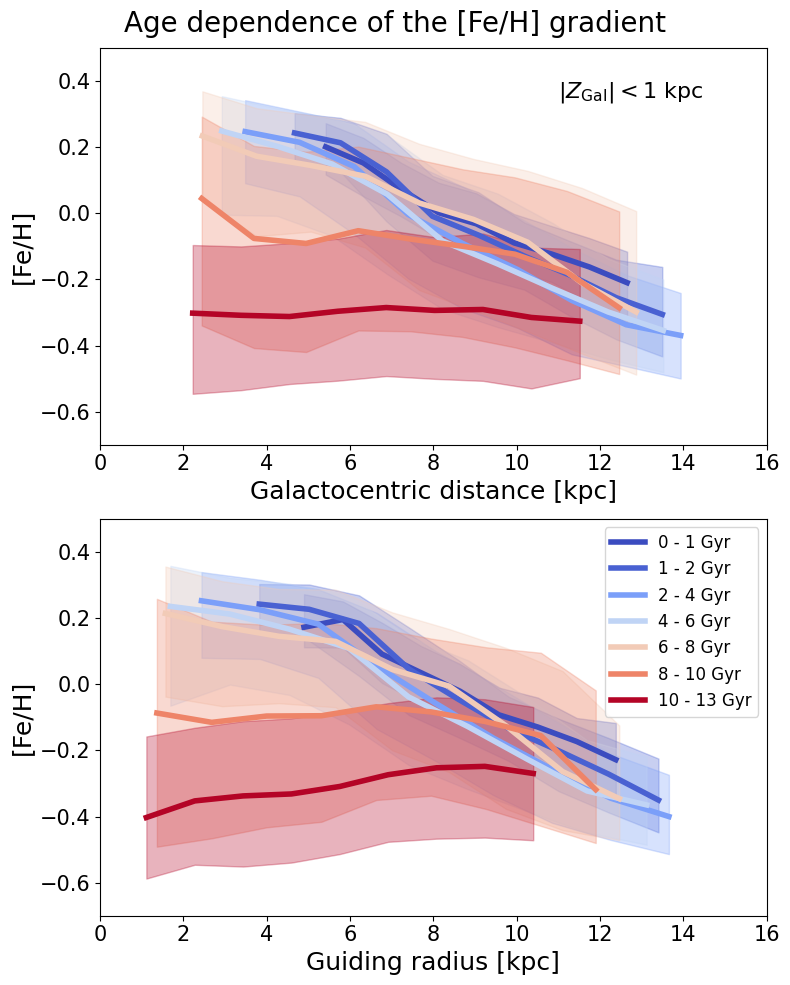

In [20]:
f, (a0, a1) = plt.subplots(2,1, figsize=(8,10))
f.subplots_adjust(right=0.8)

plot_cbar = False
rfe_range = [0, 16, -.7, .5]
ageranges = [[0,1], [1,2], [2,4], [4,6], [6,8], [8,10], [10,13]] 
dfedr     = np.zeros(len(ageranges))
sigfe     = np.zeros(len(ageranges))
dfedrg    = np.zeros(len(ageranges))
sigfeg    = np.zeros(len(ageranges))
rrange    = [4, 12]

import matplotlib as mpl
cmap = plt.get_cmap('coolwarm')
norm = mpl.colors.Normalize(vmin=1, vmax=11)

plt.axes(a0)
for ii in np.arange(len(ageranges)):
    cut_ii = (our_cat['spec_age_feb2023'] > ageranges[ii][0]) & \
             (our_cat['spec_age_feb2023'] < ageranges[ii][1]) & \
             (abs(our_cat['Zg']) < 1.) & (np.isfinite(our_cat['FE_H']))
    print(np.sum(cut_ii))
    Rs, med, q16, q84, N = running_median(our_cat['Rg'][cut_ii], our_cat['FE_H'][cut_ii], nbins=10)
    med = np.array(med)
    dfedr[ii] = np.polyfit(Rs[(Rs>rrange[0]) & (Rs<rrange[1])], med[(Rs>rrange[0]) & (Rs<rrange[1])], 1)[0]
    sigfe[ii] = np.mean(0.5 * (np.array(q84)-np.array(q16)))
    l = overplot_trend(our_cat['Rg'][cut_ii], our_cat['FE_H'][cut_ii], 
                       alpha=0.3, bins=10, lw=4, 
                       color=cmap(norm(0.5*(ageranges[ii][0]+ageranges[ii][1]))),
                       label=str(ageranges[ii][0])+r" - "+str(ageranges[ii][1])+r" Gyr")

a0.axis(rfe_range)
a0.set_xlabel(r"Galactocentric distance [kpc]", fontsize=18)
a0.set_ylabel(r"[Fe/H]", fontsize=18)
plt.text(11, 0.35, r"$|Z_{\rm Gal}|<1$ kpc", fontsize=16)

plt.axes(a1)
for ii in np.arange(len(ageranges)):
    cut_ii = (our_cat['spec_age_feb2023'] > ageranges[ii][0]) & \
             (our_cat['spec_age_feb2023'] < ageranges[ii][1]) & \
             (abs(our_cat['Zg']) < 1.) & (np.isfinite(our_cat['FE_H'])) & (our_cat['Rc']>0)
    Rs, med, q16, q84, N = running_median(our_cat['Rc'][cut_ii], our_cat['FE_H'][cut_ii], nbins=10)
    med = np.array(med)
    dfedrg[ii] = np.polyfit(Rs[(Rs>rrange[0]) & (Rs<rrange[1])], med[(Rs>rrange[0]) & (Rs<rrange[1])], 1)[0]
    sigfeg[ii] = np.mean(0.5 * (np.array(q84)-np.array(q16)))
    l = overplot_trend(our_cat['Rc'][cut_ii], our_cat['FE_H'][cut_ii], 
                       alpha=0.3, bins=10, lw=4,
                       color=cmap(norm(0.5*(ageranges[ii][0]+ageranges[ii][1]))),
                       label=str(ageranges[ii][0])+r" - "+str(ageranges[ii][1])+r" Gyr")

plt.legend(loc="upper right", fontsize=12)

a1.axis(rfe_range)
a1.set_xlabel(r"Guiding radius [kpc]", fontsize=18)
a1.set_ylabel(r"[Fe/H]", fontsize=18)

plt.suptitle("Age dependence of the [Fe/H] gradient", fontsize=20)
if plot_cbar:
    fakedots = plt.scatter(-our_cat['Rc'][10], -our_cat['Rc'][10], 
                       c=our_cat['spec_age_feb2023'][10], vmin=1, vmax=11, cmap=cmap)

    cbar_ax = f.add_axes([0.85, 0.15, 0.03, 0.7])
    cax = f.colorbar(fakedots, cax=cbar_ax, label="Age [Gyr]")
    cax.set_label(r"Age [Gyr]", fontsize=16)
else:
    plt.tight_layout()
plt.savefig("../im/Rfe_agecoloured.png")

/tmp/ipykernel_4528/3192593307.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(xarr, yarr, c="k", ls="dashdot", fmt = 'o-', markersize=10,


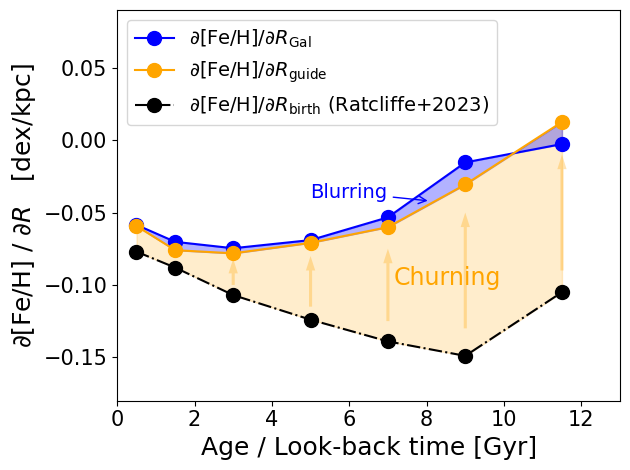

In [74]:
# Age array
xarr =  np.array([0.5*(a[0]+a[1]) for a in ageranges])

# Plot poor man's gradient computation
plt.errorbar(xarr, dfedr, markersize=10,
             fmt = 'o-', c="b", label=r"$\partial$[Fe/H]/$\partial R_{\rm Gal}$")
plt.errorbar(xarr, dfedrg, markersize=10,
             fmt = 'o-', c="orange", label=r"$\partial$[Fe/H]/$\partial R_{\rm guide}$")

# Overplot Bridget's gradients (read off her Fig. 5)
yarr = -np.array([0.077, 0.088, 0.107, 0.124, 0.139, 0.149, 0.105 ])
plt.errorbar(xarr, yarr, c="k", ls="dashdot", fmt = 'o-', markersize=10,
             label=r"$\partial$[Fe/H]/$\partial R_{\rm birth}$ (Ratcliffe+2023)")

# Shaded regions
plt.fill_between(xarr, yarr, dfedrg, alpha=0.2, zorder=0, color="orange")
plt.fill_between(xarr, dfedr, dfedrg, alpha=0.3, zorder=0, color="blue")
# Arrows
arr_x = [3,5,7,9,11.5]
arr_y = [-.1, -.115, -.125, -.13, -.09]
dy    = [.008, .025, .04, .07, .07]
for ii in np.arange(len(dy)):
    plt.arrow(x=arr_x[ii], y=arr_y[ii], dx=0, dy=dy[ii], 
              width=.08, head_length=.01, alpha=0.3, facecolor='orange', edgecolor='none')
plt.text(7.15, -.1, r"Churning", fontsize=17, color="orange")
#plt.text(7.15, -.1, r"Blurring", fontsize=15, color="blue")
plt.annotate(r"Blurring", fontsize=14, color="blue",
            xy=(8.1, -0.042), xycoords='data',
            xytext=(5, -0.04), textcoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color="b"))

plt.legend(loc="upper left", fontsize=14)

plt.axis([0,13,-.18, 0.09])
plt.xlabel(r"Age / Look-back time [Gyr]", fontsize=18)
plt.ylabel(r"$\partial$[Fe/H] / $\partial R$   [dex/kpc]", fontsize=18)

plt.tight_layout()
plt.savefig("../im/dfedr_age.png")

## Age - velocity dispersion relation in bins of R

6996
16156
58396
41293
14627


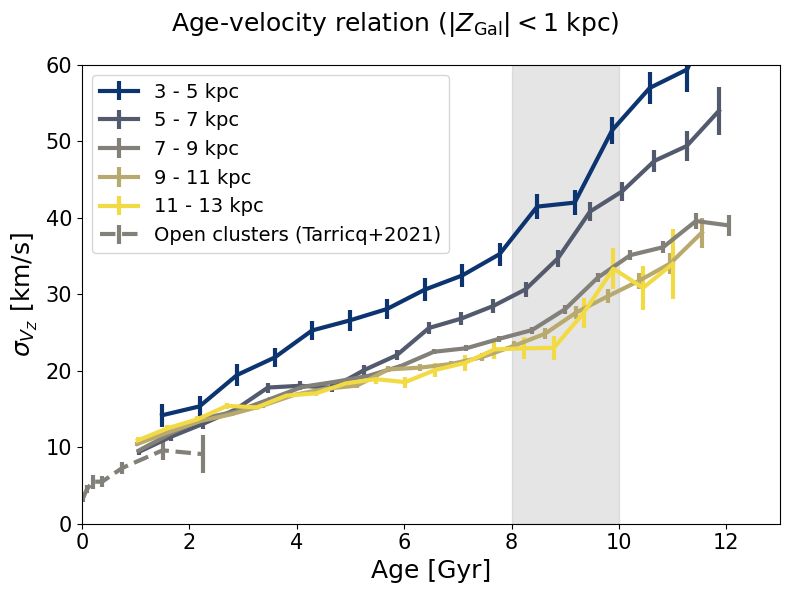

In [128]:
f, (a0) = plt.subplots(1,1, figsize=(8,6))
f.subplots_adjust(right=0.8)

plot_cbar = False
Rbins     = [[3,5], [5,7], [7,9], [9,11], [11, 13]]

import matplotlib as mpl
cmap = plt.get_cmap('cividis', 20)
norm = mpl.colors.Normalize(vmin=3, vmax=13)

plt.axes(a0)
for ii in np.arange(len(Rbins)):
    cut_ii = (our_cat['Rg'] > Rbins[ii][0]) & \
             (our_cat['Rg'] < Rbins[ii][1]) & \
             (abs(our_cat['Zg']) < 1.) & (np.isfinite(our_cat['vZg']))
    N_ii = np.sum(cut_ii)
    print(N_ii)
    ages, med, q16, q84, N = running_median(our_cat['spec_age_feb2023'][cut_ii], 
                                         our_cat['vZg'][cut_ii], nbins=np.minimum(int(N_ii / 400), 20))
    
    plt.errorbar(np.array(ages), 0.5*(np.array(q84)-np.array(q16)), ms=50, lw=3, ls="solid",
             color=cmap(norm(0.5*(Rbins[ii][0]+Rbins[ii][1]))), 
                   yerr=0.5*(np.array(q84)-np.array(q16))/np.sqrt(N),
             label=str(Rbins[ii][0])+r" - "+str(Rbins[ii][1])+r" kpc")

    
# Adding the (local) OC measurements from Tarricq+2021, Table 3:
ages_t = [0.015, 0.09, 0.2, 0.375, 0.75, 1.5, 2.25]
sigs_t = [3.3, 4.5, 5.5, 5.5, 7.3, 9.6, 9.1]
errs_t = [.5,.5,.9,.7,.8,1.2,2.5]

plt.errorbar(ages_t, sigs_t, ms=50, lw=3, ls="dashed",
             color=cmap(norm(8.2)), yerr=errs_t,
             label="Open clusters (Tarricq+2021)")

plt.legend(loc="upper left", fontsize=14)
a0.axis([0,13,0,60])
a0.set_xlabel(r"Age [Gyr]", fontsize=18)
a0.set_ylabel(r"$\sigma_{V_Z}$ [km/s]", fontsize=18)
a0.fill_between(np.linspace(8,10,10), 0, 100, alpha=0.2, zorder=0, color="grey")

#plt.text(10.05, 11, r"$|Z_{\rm Gal}|<1$ kpc", fontsize=16)
plt.suptitle(r"Age-velocity relation ($|Z_{\rm Gal}|<1$ kpc)", fontsize=18)
plt.tight_layout()
plt.savefig("../im/age_sigvz_Rbins.png")

10688
28820
57706
30701
7705
1114


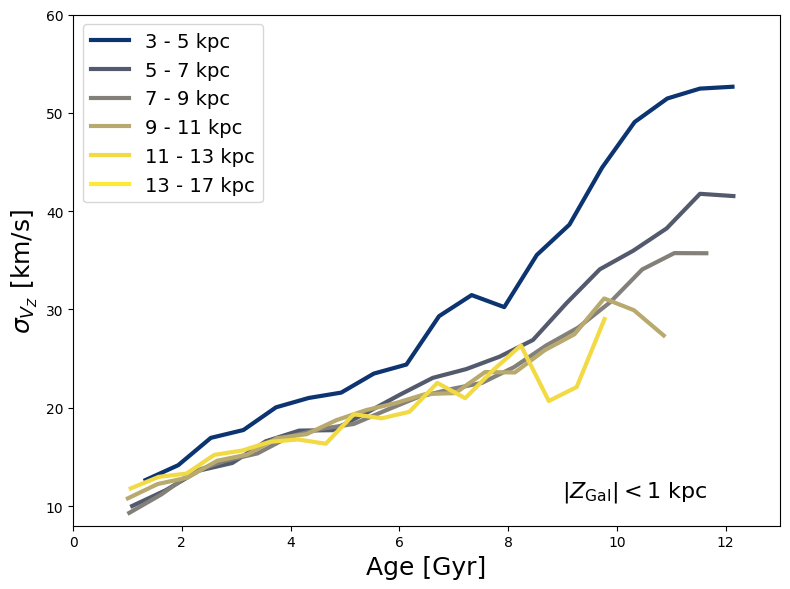

In [22]:
f, (a0) = plt.subplots(1,1, figsize=(8,6))
f.subplots_adjust(right=0.8)

plot_cbar = False
Rbins     = [[3,5], [5,7], [7,9], [9,11], [11, 13], [13, 17]]

import matplotlib as mpl
cmap = plt.get_cmap('cividis', 20)
norm = mpl.colors.Normalize(vmin=3, vmax=13)

plt.axes(a0)
for ii in np.arange(len(Rbins)):
    cut_ii = (our_cat['Rc'] > Rbins[ii][0]) & \
             (our_cat['Rc'] < Rbins[ii][1]) & \
             (abs(our_cat['Zg']) < 1.) & (np.isfinite(our_cat['vZg']))
    N_ii = np.sum(cut_ii)
    print(N_ii)
    ages, med, q16, q84 = running_median(our_cat['spec_age_feb2023'][cut_ii], 
                                         our_cat['vZg'][cut_ii], nbins=np.minimum(int(N_ii / 400), 20))
    plt.plot(np.array(ages), 0.5*(np.array(q84)-np.array(q16)), ms=50, lw=3, 
             color=cmap(norm(0.5*(Rbins[ii][0]+Rbins[ii][1]))),
             label=str(Rbins[ii][0])+r" - "+str(Rbins[ii][1])+r" kpc")

plt.legend(loc="upper left", fontsize=14)
a0.axis([0,13,8,60])
a0.set_xlabel(r"Age [Gyr]", fontsize=18)
a0.set_ylabel(r"$\sigma_{V_Z}$ [km/s]", fontsize=18)

plt.text(9, 11, r"$|Z_{\rm Gal}|<1$ kpc", fontsize=16)
plt.tight_layout()
plt.savefig("../im/age_sigvz_Rguidebins.png")